In [1]:
import pandas as pd
import numpy as np

#library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

#library analisis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#library forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
data = pd.read_excel ('dataset.xlsx')
data.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


Transform data time

In [4]:
data['Year'] = pd.to_datetime(data['Year'], format='%Y')

In [5]:
data.set_index(['Year'], inplace=True)

In [6]:
data.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [7]:
data.index.min(), data.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [8]:
if (data.index.max() - data.index.min() == 214):
    print('Data Kontinyu')

In [9]:
data.index.freq='YS'

analisis time series

<Axes: xlabel='Year'>

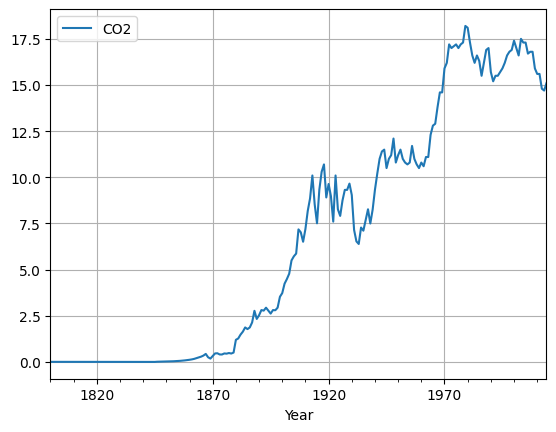

In [10]:
data.plot(grid=True)

cek data stasioner atau tidak

In [11]:
train_data = data.loc[:'1991-01-01']
test_data = data.loc['1992-01-01':]

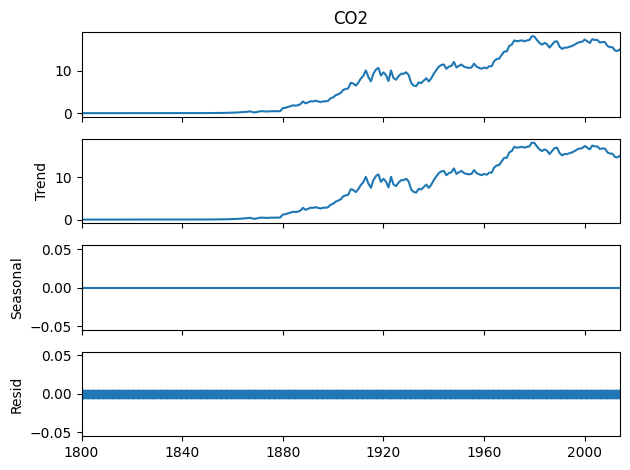

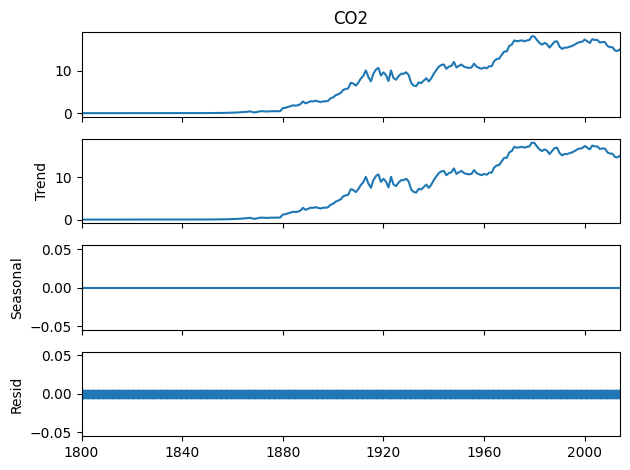

In [12]:
decompose_add = seasonal_decompose(data['CO2'])
decompose_add.plot()

In [13]:
def adf_test(timeseries):
    print ('Hasil Tes Dickey-Fuller:')
    print ('----------------------------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adftest[4].items():
        adf_output['Critical Value (%s)'%key] = value
    print (adf_output)


adf_test(data.values)

Hasil Tes Dickey-Fuller:
----------------------------------------------
Test Statistic                  -0.378463
p-value                          0.913633
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%)             -3.461282
Critical Value (5%)             -2.875143
Critical Value (10%)            -2.574020
dtype: float64


p value lebih dari 0.05 maka data diatas merupaka data non stasioner

menggunakan metode differencing untuk transform data

In [14]:
diff_data = data.diff()
diff_data.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [15]:
diff_data.dropna(inplace=True)

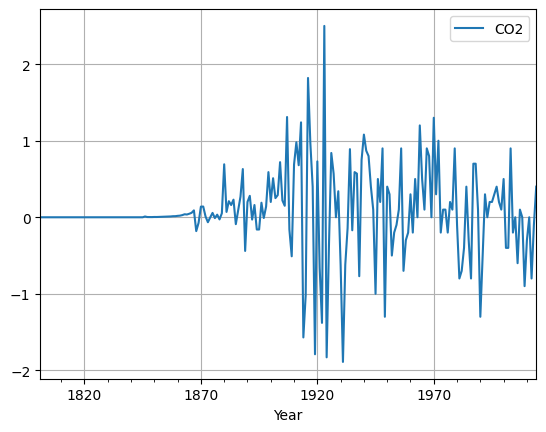

In [16]:
diff_data.plot(grid=True);

In [17]:
adf_test(diff_data)

Hasil Tes Dickey-Fuller:
----------------------------------------------
Test Statistic                  -3.780005
p-value                          0.003119
#Lags Used                      15.000000
Number of Observations Used    198.000000
Critical Value (1%)             -3.463815
Critical Value (5%)             -2.876251
Critical Value (10%)            -2.574611
dtype: float64


terlihat bahwa p-value menjadi kurang dari 0.05

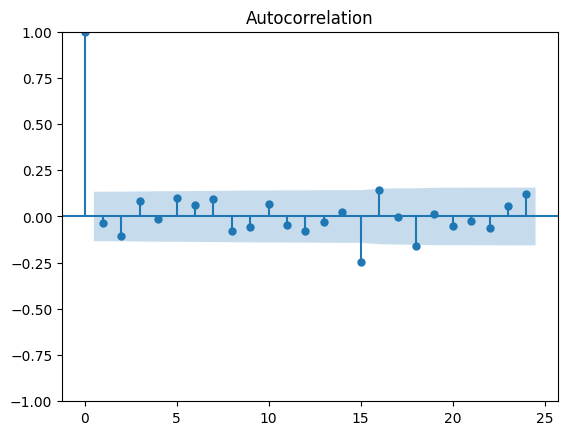

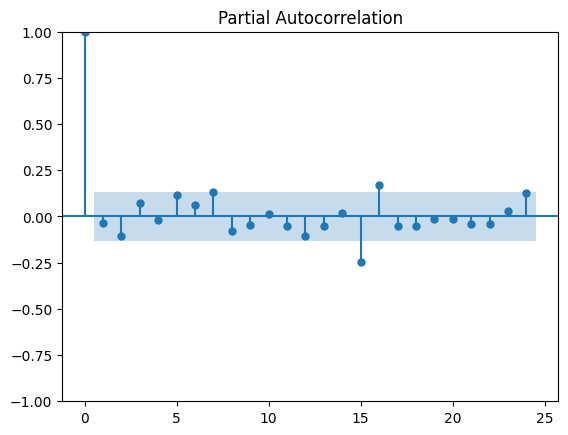

In [18]:
plot_acf(diff_data);
plot_pacf(diff_data);

SINGLE EXPONENTIAL SMOOTHING

In [19]:
single_exp = SimpleExpSmoothing(train_data).fit()
single_exp_train_pred = single_exp.fittedvalues
single_exp_test_pred = single_exp.forecast(23)

<Axes: xlabel='Year'>

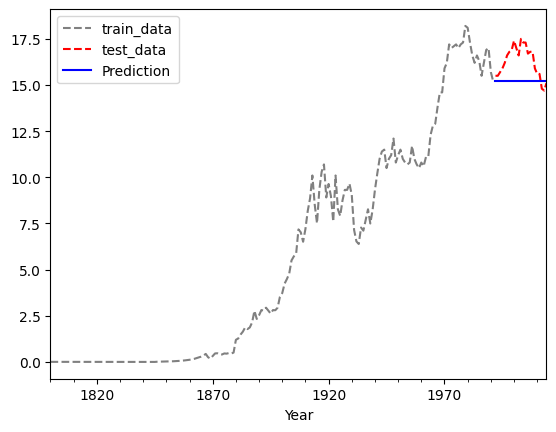

In [20]:
train_data['CO2'].plot(style='--', color='gray', legend=True, label='train_data')
test_data['CO2'].plot(style='--', color='r', legend=True, label='test_data')
single_exp_test_pred.plot(color='b', legend=True, label='Prediction')

In [21]:
print('Train RMSE:',mean_squared_error(train_data, single_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_data, single_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_data, single_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_data, single_exp_test_pred))

Train RMSE: 0.5646920026800211
Test RMSE: 1.3429113022690757
Train MAPE: 0.08470457297144984
Test MAPE: 0.06861466412071282


DOUBLE EXPONENTIAL SMOOTHING

In [22]:
double_exp = ExponentialSmoothing(train_data, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=29, damped_trend=False).fit()
double_exp_train_pred = double_exp.fittedvalues
double_exp_test_pred = double_exp.forecast(23)

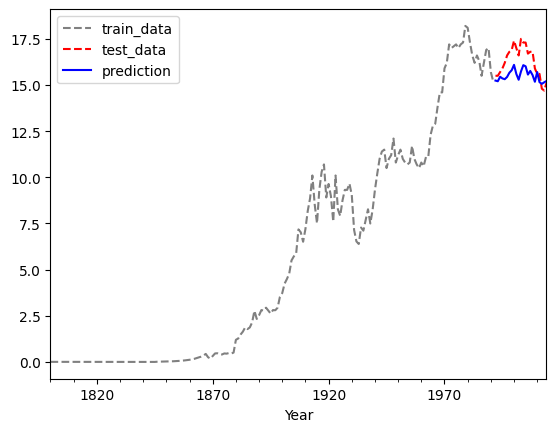

In [23]:
train_data['CO2'].plot(style='--', color='gray', legend=True, label='train_data')
test_data['CO2'].plot(style='--', color='r', legend=True, label='test_data')
double_exp_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [24]:
print('Train RMSE:',mean_squared_error(train_data, double_exp_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_data, double_exp_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_data, double_exp_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_data, double_exp_test_pred))

Train RMSE: 0.5576263311585985
Test RMSE: 0.9739218118065314
Train MAPE: 14.722686125796463
Test MAPE: 0.05078156771942895


ARIMA

In [25]:
# we got the p,d,q value from time series analysis
ar = ARIMA(train_data, order=(15,1,15)).fit()
ar_train_pred = ar.fittedvalues
ar_test_pred = ar.forecast(23)

/home/jar/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


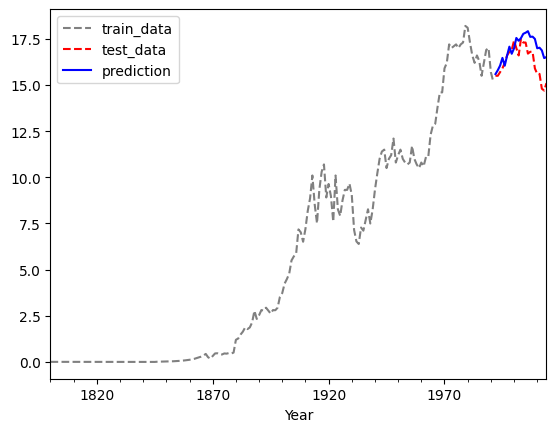

In [26]:
train_data['CO2'].plot(style='--', color='gray', legend=True, label='train_data')
test_data['CO2'].plot(style='--', color='r', legend=True, label='test_data')
ar_test_pred.plot(color='b', legend=True, label='prediction')
plt.show()

In [27]:
print('Train RMSE:',mean_squared_error(train_data, ar_train_pred)**0.5)
print('Test RMSE:',mean_squared_error(test_data, ar_test_pred)**0.5)
print('Train MAPE:',mean_absolute_percentage_error(train_data, ar_train_pred))
print('Test MAPE:',mean_absolute_percentage_error(test_data, ar_test_pred))

Train RMSE: 0.46789155092662843
Test RMSE: 0.9558554345394793
Train MAPE: 0.08136936208869378
Test MAPE: 0.04743188231052615


PERBANDINGAN ALGORITMA

In [28]:
comparision_data = pd.DataFrame(data=[
    ['Single exp smoothing', 1.3429 , 0.0686],
    ['double exp smoothing', 0.9739,  0.0507],
    ['ARIMA(15,1,15)', 0.9558, 0.04743],
    ],
    columns = ['Model', 'RMSE', 'MAPE'])
comparision_data.set_index('Model', inplace=True)

In [29]:
comparision_data.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
"ARIMA(15,1,15)",0.9558,0.04743
double exp smoothing,0.9739,0.05070
Single exp smoothing,1.3429,0.06860


In [30]:
arima = ARIMA (data, order=(15,1,15)).fit()
arima_pred=arima.forecast(30)

/home/jar/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


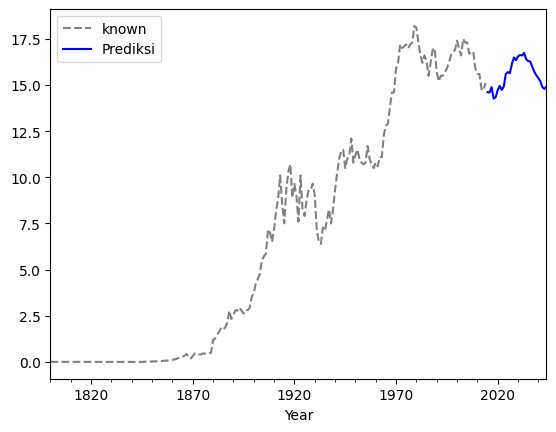

In [31]:
data['CO2'].plot(style='--', color='gray', legend=True, label='known')
arima_pred.plot(style='b', legend=True, label='Prediksi')
plt.show()

In [32]:
import pickle

In [33]:
pickle.dump(arima, open('prediksi.sav', 'wb'))